# Background
---
One of the nicer sources of data out there for whisk(e)y is [Selfbuilt's Whisky Analysis](https://whiskyanalysis.com/). Their site contains a highly curated database of reviews with detailed metadata (you can read more about the methodology for their review selection [here](https://whiskyanalysis.com/index.php/methodology-introduction/)). For each whisk(e)y, the average review score (on a 10 point scale) and number of reviews is reported.

I'm interested in seeing what their whiskey data looks like on a high level, but also to investigate what happens when I apply a rating scheme that accounts for uncertainty based on the number of reviews (e.g. the [Wilson score](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Wilson_score_interval)). Perhaps one could also incorporate price, and calculate a "bang for your buck" rating.

I'm also interested in comparing opinions from different sources. There are blind taste tests of commonly-available (or "shelf") whisk(e)ys—for example, [this one](https://www.bourbonbanter.com/banter/how-the-bourbon-crusaders-determined-the-best-bourbons-on-the-shelf/)—that attempt to identify the "best" products that are widely available. I'm curious about how the top picks amongst easy-to-find bottles fare against the full field, which includes rarer bottles.

# Setup
---

In [1]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sps
import seaborn as sns

In [2]:
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

# Load and Munge Data
---

## Selfbuilt Data

Load the [Selfbuilt Whisky Database](https://whiskyanalysis.com/index.php/database/) data:

In [3]:
filepath = "data/selfbuilt/whiskey_database.csv"

# Rename columns
my_column_names = {
    "Whisky": "Whisk(e)y",
    "Meta Critic": "Reported Score",
    "STDEV": "Reported Score Standard Deviation",
    "#": "Number of Reviews",
    "Class": "Mash",
}

data = pd.read_csv(filepath).rename(columns=my_column_names)

In [4]:
# Map the "cost" column to a numerical "cost_ranking" column,
# and make the "cost" columng more human-readable
data["Cost Ranking"] = data["Cost"].apply(
    lambda s: len(s) if isinstance(s, str) else None
)

cost_tiers = {
    "$" : "< \$30 CAD",
    "$$" : "\$30-\$50 CAD",
    "$$$" : "\$50-\$70 CAD",
    "$$$$" : "\$70-\$125 CAD",
    "$$$$$" : "\$125-\$300 CAD",
    "$$$$$+" : "> \$300 CAD",
}
data["Cost"] = data["Cost"].map(cost_tiers)

In [5]:
# Normalize the scores to be between 0 and 1
data["Reported Score"] = data["Reported Score"] / 10

## Blind Tasting Data

These are the top ten "shelf bourbons" according to [this tasting](https://www.bourbonbanter.com/banter/how-the-bourbon-crusaders-determined-the-best-bourbons-on-the-shelf/):

In [6]:
blind_top_10 = [
    "Old Bardstown Bottled-In-Bond",
    "Old Grand-Dad Bourbon 100 BiB",
    "Woodford Reserve Distiller's Select",
    "Elijah Craig Small Batch (NAS)",
    "Michter's Small Batch US*1 Bourbon",
    "Old Forester 1920 Prohibition Style",
    "Buffalo Trace Bourbon",
    "Bulleit 10yo",
    "Henry McKenna 10yo Single Barrel BiB",
    "Russell's Reserve Single Barrel",
]

In [7]:
# Flag the blind taste test top 10
data["Blind Top 10"] = data["Whisk(e)y"].isin(blind_top_10)

# Getting to Know the Dataset
---

## Quick look
Most columns are self-explanatory. There are a couple that may not be obvious: 
* `mash` is a high-level descriptor of the recipe of grains that went into the whisk(e)y, and is more or less ground truth
* `super_cluster` and `cluster` are flavor designations determined by Selfbuilt, and may be more a subjective determination

In [8]:
data.head()

,Whisk(e)y,Reported Score,Reported Score Standard Deviation,Number of Reviews,Cost,Mash,Super Cluster,Cluster,Country,Type,Cost Ranking,Blind Top 10
0,Mister Sam Tribute Whisky,0.951,0.15,4,\$125-\$300 CAD,Rye-like,NaN,NaN,Canada,Blend,5.0,False
1,Port Ellen 2nd release 24yo 59.35%,0.948,0.21,7,> \$300 CAD,SingleMalt-like,I,I,Scotland,Malt,6.0,False
2,Ledaig 42yo Dusgadh,0.946,0.24,3,> \$300 CAD,SingleMalt-like,ABC,C,Scotland,Malt,6.0,False
3,Port Ellen 9th release 30yo,0.946,0.11,5,> \$300 CAD,SingleMalt-like,I,I,Scotland,Malt,6.0,False
4,Brora 35yo,0.942,0.31,12,> \$300 CAD,SingleMalt-like,J,J,Scotland,Malt,6.0,False


## Plotting

### Scores and Review Counts
Let's start with a simple plot of the scores and the number of reviews.

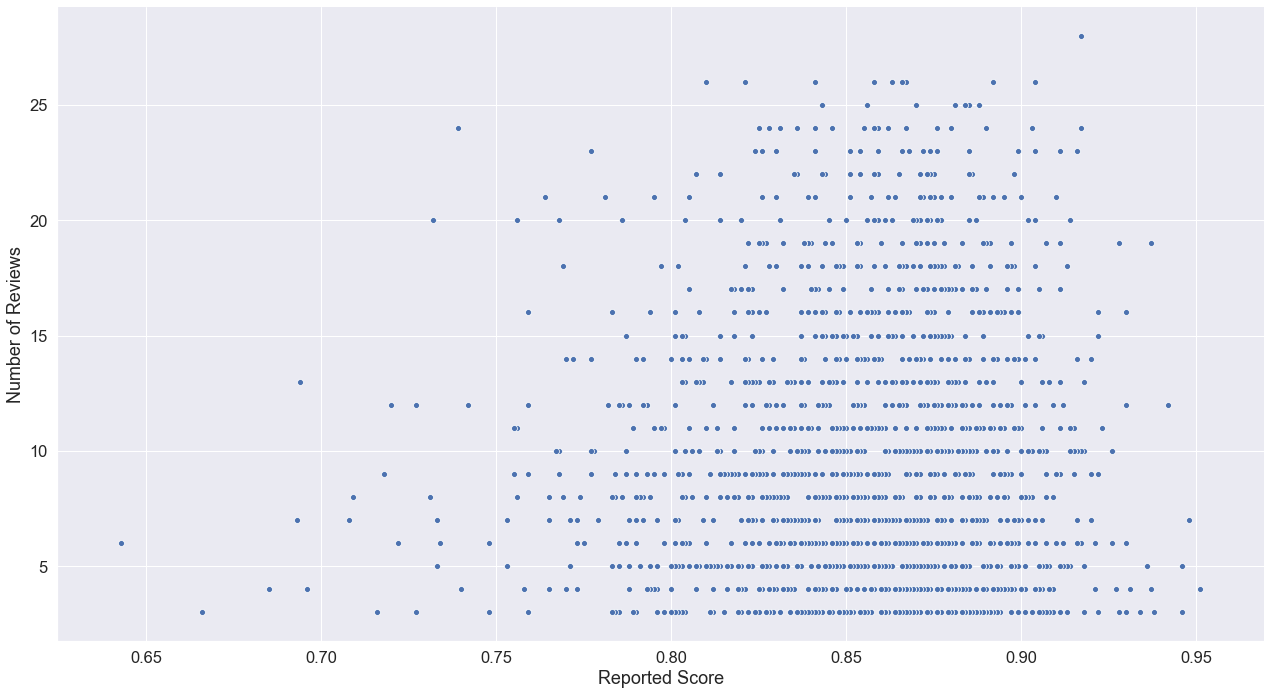

In [9]:
sns.relplot("Reported Score", "Number of Reviews", data=data, height=10, aspect=1.8);

Looks like we have a wide range of scores, several of them based on very few reviews. This means that just sorting by score is not likely to give us the best results. For example, how much should we trust the ratings of all those whisk(e)ys in the lower right corner? Their average ratings may be high, but if you're trying to be a discerning shopper and can only buy one item, perhaps you'd rather opt for something rated slightly lower, but rated by more people.

### Bourbons (including blind taste test winners)

Let's look just at Bourbons now, and color those that won the "blind top 10" tasting.

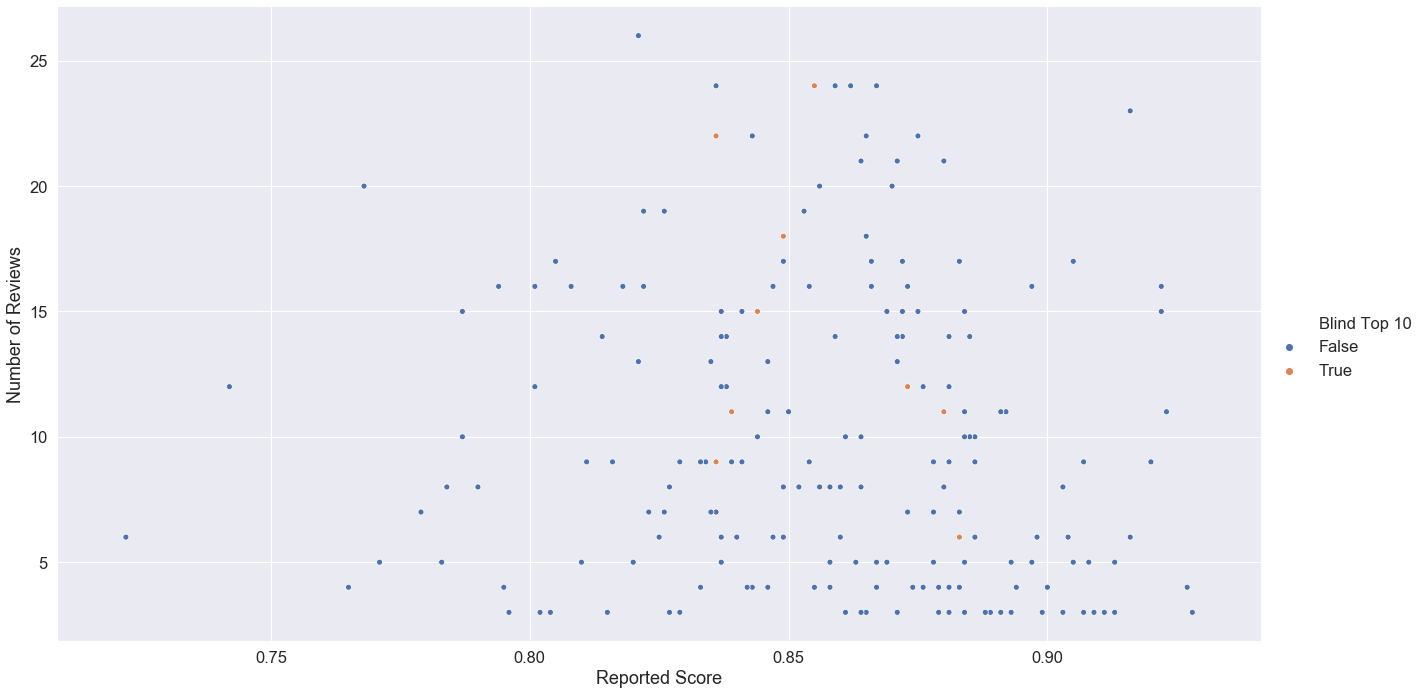

In [10]:
sns.relplot("Reported Score", "Number of Reviews", data=data[data["Type"]=="Bourbon"], hue="Blind Top 10", height=10, aspect=1.8);

In general, the higher the score, the lower the standard deviation on the score:

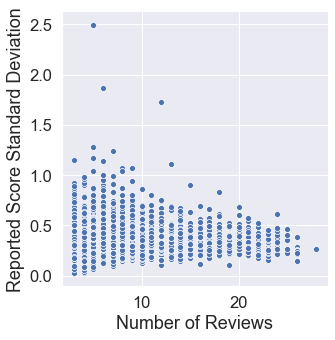

In [11]:
sns.relplot("Number of Reviews", "Reported Score Standard Deviation", data=data);

### Score distributions

Let's define a convenience function for looking at score distribution by a categorical variable.

In [12]:
def categorical_numerical_grid(categorical, numerical, data, order_col=None, plot_func=partial(sns.kdeplot, shade=True), **kwargs):
    """Make a grid of plots that show the distribution of a numerical variable cut by a categorical variable.
    
    Parameters
    ----------
    categorical : str
        The column name of a categorical variable.
    numercial : str
        The column name of a numerical variable.
    data : pandas.DataFrame
        The data from which to construct the plot.
    order_col : str, optional
        If not `None` (default), use this column to determine the order of the categorical values.
    plot_func : function, optional
        Seaborn plotting function to pass to seaborn.FacetGrid.map().
    **kwargs
        Extra arguments to pass to seaborn.FacetGrid.
    """
    
    plot_data = data[~data[categorical].isna()]
    row_order = plot_data.sort_values(order_col)[categorical].unique() if order_col else None
    
    grid = sns.FacetGrid(
        plot_data,
        hue=categorical,
        aspect=3,
        height=2,
        row_order=row_order,
        **kwargs
    )
    grid.map(plot_func, numerical, label=categorical);
    return grid

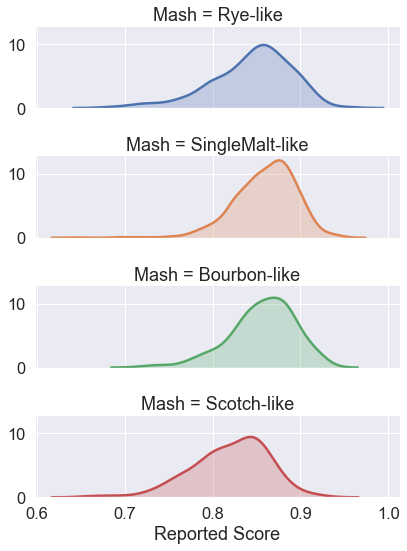

In [13]:
categorical_numerical_grid("Mash", "Reported Score", data, row="Mash");

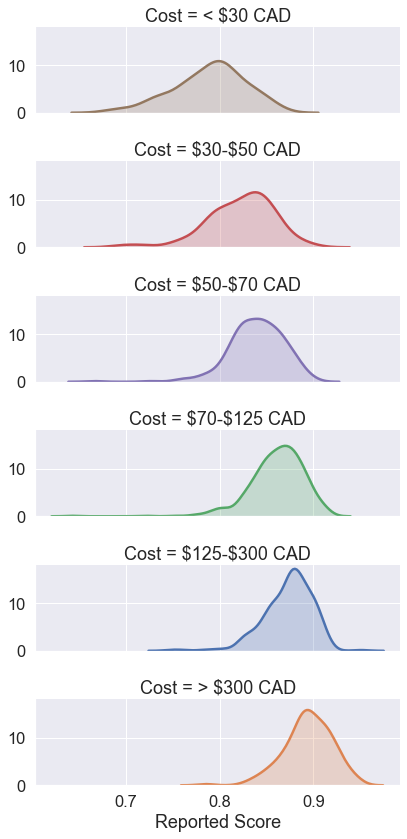

In [14]:
categorical_numerical_grid("Cost", "Reported Score", data, row="Cost", order_col="Cost Ranking");

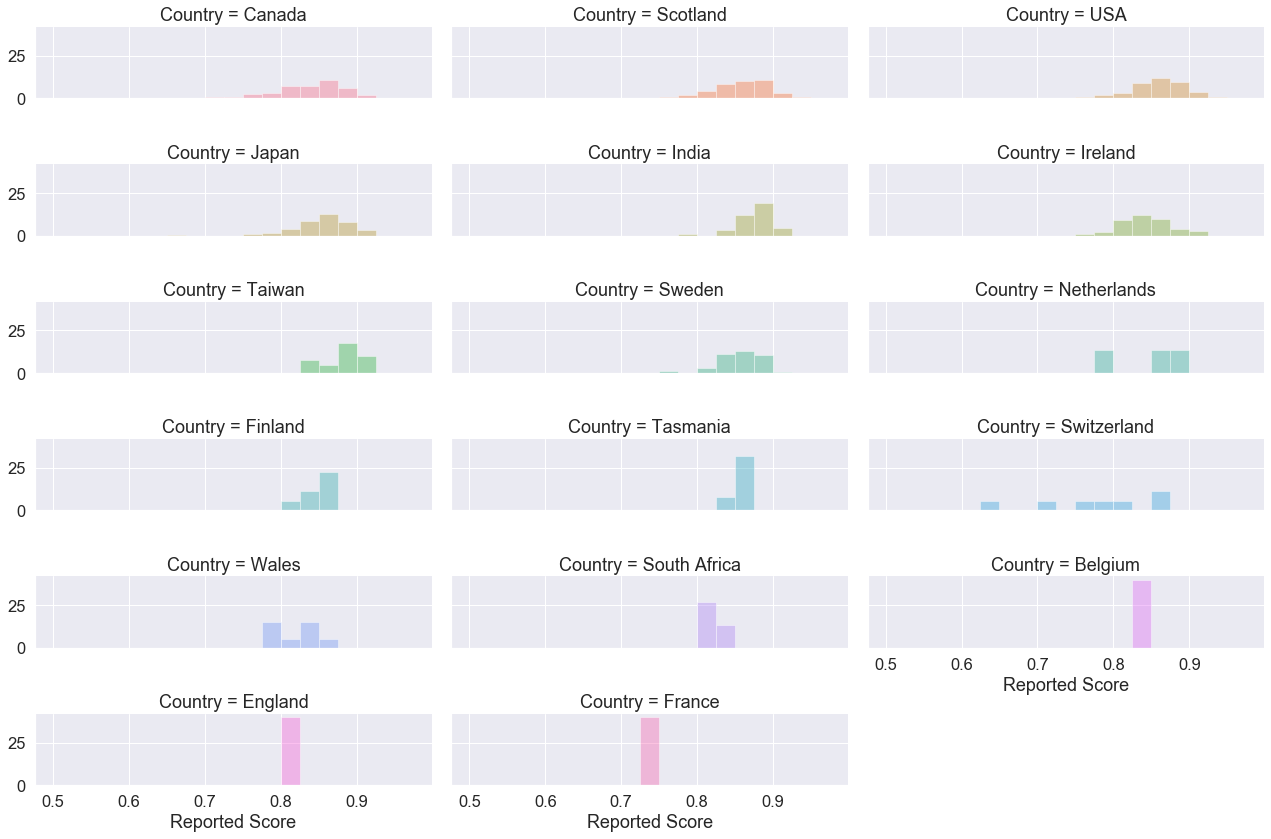

In [15]:
categorical_numerical_grid(
    "Country",
    "Reported Score",
    data,
    plot_func=partial(sns.distplot, kde=False, bins=np.arange(0.5, 1, 0.025), norm_hist=True),
    col="Country",
    col_wrap=3,
);

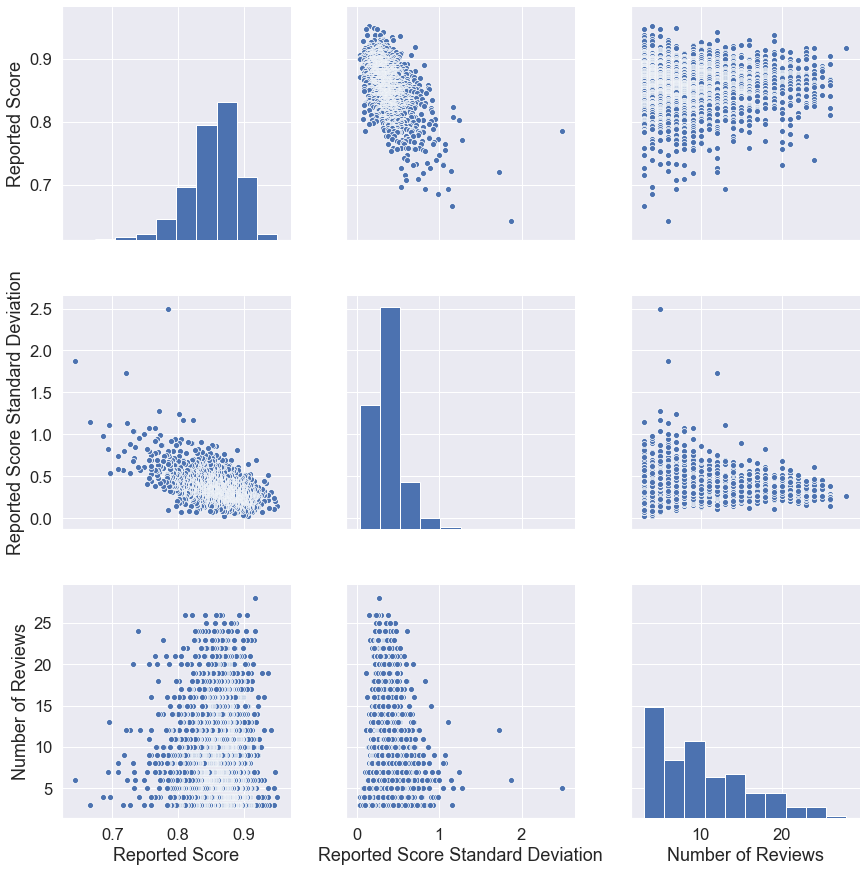

In [16]:
sns.pairplot(
    data,
    vars=[
        "Reported Score",
        "Reported Score Standard Deviation",
        "Number of Reviews",
    ],
    diag_kind="hist",
    height=4,
);

# A Sample Size-Aware Rating

What's a good way of accounting for both rating and sample size? Another way we might ask this question is: how much should we "discount" a rating for having a low sample size?

Thankfully we have [Edwin Bidwell Wilson](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Wilson_score_interval) to thank for devising a good way of answering this question, and [Evan Miller](https://www.evanmiller.org/how-not-to-sort-by-average-rating.html) for helping spread the message.

In [17]:
@np.vectorize
def wilson_score(avg, n, alpha=0.95, bound="lower"):
    """The normalized rating given by the Wilson score confidence interval for a Bernoulli parameter.
    
    The Wilson score confidence interval really gives us two values, the lower and upper
    bounds. In most cases we want just one of the two. If we're sorting by highest ranking,
    we want the lower bound, so ``"lower"`` is the default value returned.
    
    Parameters
    ----------
    avg : float
        The average rating (normalized to be between 0 and 1).
    n : int
        The number of reviews.
    alpha : float, optional
        Confidence level to use when calculating the binomial proportion confidence interval. Default 0.95.
    bound : {"lower", "upper"}, optional
        Whether the lower or upper bound of confidence interval is desired. Default 'lower'.
    """
    
    if n <= 0:
        raise ValueError("n must be at least 1")
    
    z = sps.norm.ppf(1-(1-alpha)/2)
    center = avg + 0.5 * (z**2/n)
    distance_to_bound = z * np.sqrt((avg*(1-avg))/n + z**2/(4*n**2))
    denominator = 1 + z**2/n
    
    if bound == "lower":
        numerator = center - distance_to_bound  
    elif bound == "upper":
        numerator = center + distance_to_bound  
    else:
        raise ValueError(f"bound must be 'upper' or 'lower', got '{bound}'")
    
    return numerator / denominator

Let's take a look at an example of how the Wilson score "discounts" a rating based on sample size.

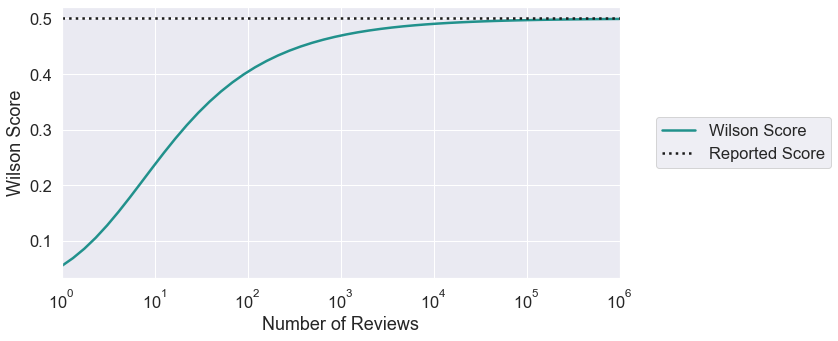

In [18]:
sample_sizes = np.logspace(0, 6)
reported_score = 0.5 

plt.figure(figsize=(10,5))

plt.plot(
    sample_sizes,
    wilson_score(reported_score, sample_sizes),
    label=f"Wilson Score",
    color=plt.cm.viridis(reported_score),
)
plt.axhline(reported_score, color="k", linestyle=":", label="Reported Score")

plt.xscale("log")
plt.xlim(np.min(sample_sizes), np.max(sample_sizes))
plt.xlabel("Number of Reviews")
plt.ylabel("Wilson Score")
plt.legend(bbox_to_anchor=(1.05, 0.5, 0, 0), loc="center left");

In this graph we see that for high sample sizes, we trust the reported score. For lower sample sizes, the score is "discounted". With a confidence level of 0.95, a score of 0.5 but only one review is discounted by nearly a factor of 10:

In [19]:
wilson_score(0.5, 1).item()

0.05462075552885201

### Wilson Score: Variation by reported score

Let's look at how the Wilson score "discounts" ratings as a function of the number of samples and the reported average score. We'll fix $\alpha=0.95$.

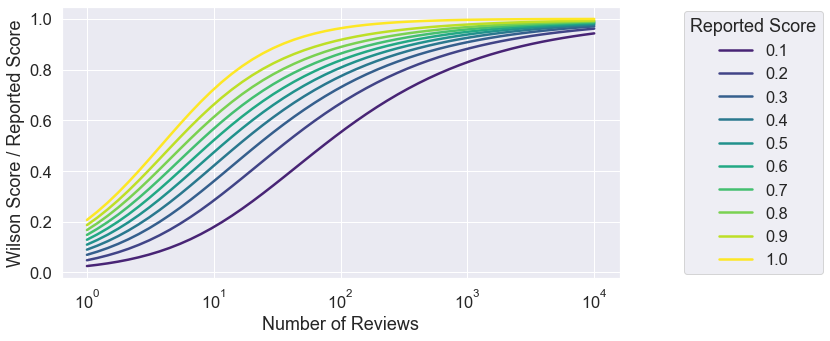

In [20]:
sample_sizes = np.logspace(0, 4)
reported_scores = np.arange(0.1, 1.1, 0.1)

plt.figure(figsize=(10,5))

# Plot a line showing the growth of the Wilson score with sample size for each reported score
for reported_score in reported_scores:
    plt.plot(
        sample_sizes,
        wilson_score(reported_score, sample_sizes, alpha=0.95) / reported_score,
        label=f"{reported_score:0.1f}",
        color=plt.cm.viridis(reported_score),
    )

plt.xlabel("Number of Reviews")
plt.ylabel("Wilson Score / Reported Score")
plt.xscale("log")
plt.legend(bbox_to_anchor=(1.1, 0.5), loc="center left", title="Reported Score");

Here we see that the absolute most we will attribute to a score with only one rating is about 20% of the actual reported rating. The Wilson score discount approaches zero more quickly for higher reported ratings, all else being equal.

### Wilson Score: Variation by desired confidence level

Suppose we pick a (normalized) score of 0.8 and instead vary $\alpha$. Depending on how confident we wish to be, the discount rate will vary.

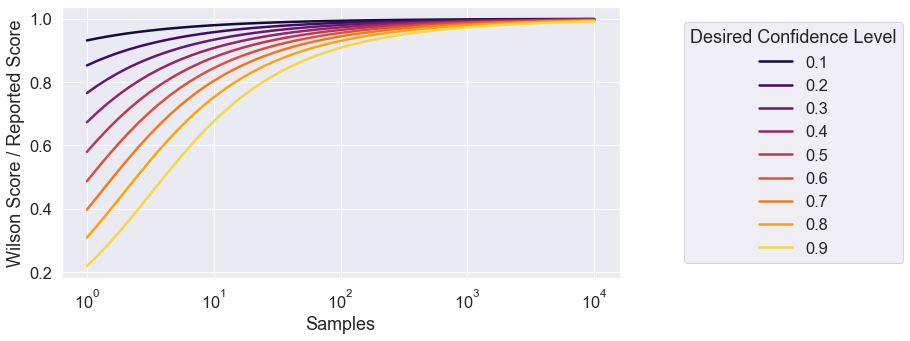

In [21]:
sample_sizes = np.logspace(0, 4)
alphas = np.arange(0.1, 1.0, 0.1)
reported_score = 0.8

plt.figure(figsize=(10,5))

# Plot a line showing the growth of the Wilson score with sample size for each reported score
for alpha in alphas:
    plt.plot(
        sample_sizes,
        wilson_score(reported_score, sample_sizes, alpha=alpha) / reported_score,
        label=f"{alpha:0.1f}",
        color=plt.cm.inferno(alpha),
    )

plt.xlabel("Samples")
plt.ylabel("Wilson Score / Reported Score")
plt.xscale("log")
plt.legend(bbox_to_anchor=(1.1, 0.5), loc="center left", title="Desired Confidence Level");

The less confidence we are comfortable having, the more we trust the score as given. Intuitively, this is most noticeable for low sample sizes. For high sample sizes we see the familiar behavior that we can trust the reported score, even when desiring a higher level of confidence.

## Applying the Wilson score to the whisk(e)y data

In [22]:
data["Wilson Score"] = data.apply(lambda row: wilson_score(row["Reported Score"], row["Number of Reviews"]), axis=1)

In [23]:
score_columns = ["Whisk(e)y", "Reported Score", "Number of Reviews", "Wilson Score"]

Let's take a look at the top 5 bottles by average score and Wilson score:

In [24]:
data[score_columns].sort_values("Reported Score", ascending=False).head(5)

,Whisk(e)y,Reported Score,Number of Reviews,Wilson Score
0,Mister Sam Tribute Whisky,0.951,4,0.462397
1,Port Ellen 2nd release 24yo 59.35%,0.948,7,0.582704
2,Ledaig 42yo Dusgadh,0.946,3,0.393252
3,Port Ellen 9th release 30yo,0.946,5,0.507792
4,Brora 35yo,0.942,12,0.677538


In [25]:
data[score_columns].sort_values("Wilson Score", ascending=False).head(5)

,Whisk(e)y,Reported Score,Number of Reviews,Wilson Score
36,Lagavulin 16yo,0.917,28,0.758464
35,Ardbeg Uigeadail,0.917,24,0.741940
7,Brora 30yo,0.937,19,0.739695
42,George T Stagg,0.916,23,0.735813
116,Highland Park 18yo,0.904,26,0.734196


The Wilson score top pick is Ron Swanson-approved!

### Wilson Score, Reported Score, and Number of Reviews

Let's see what the difference between the average score and Wilson score looks like for the whole dataset:

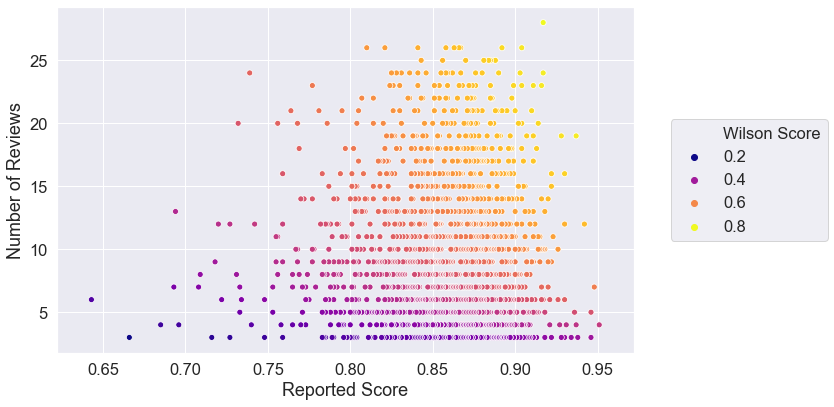

In [26]:
plt.figure(figsize=(12,6))

# Plot the whiskey data's wilson score vs. reported score
sns.scatterplot(
    "Reported Score",
    "Number of Reviews",
    data=data,
    hue="Wilson Score",
    palette="plasma",
    zorder=5,
)
plt.legend(bbox_to_anchor=(1.05, 0.5, 0, 0), loc="center left")
plt.tight_layout();

This plot shows that the Wilson score does what we want it to: it takes items with the same average score (points on the same vertical line, in this plot) and prefers those with a higher number of reviews. Intuitively, high Wilson scores occur in the upper right: an item achieves a high Wilson score by having a high average score and a high number of reviews.

Another way of plotting this is putting the Wilson score on the y axis and assigning hue based on the number of reviews:

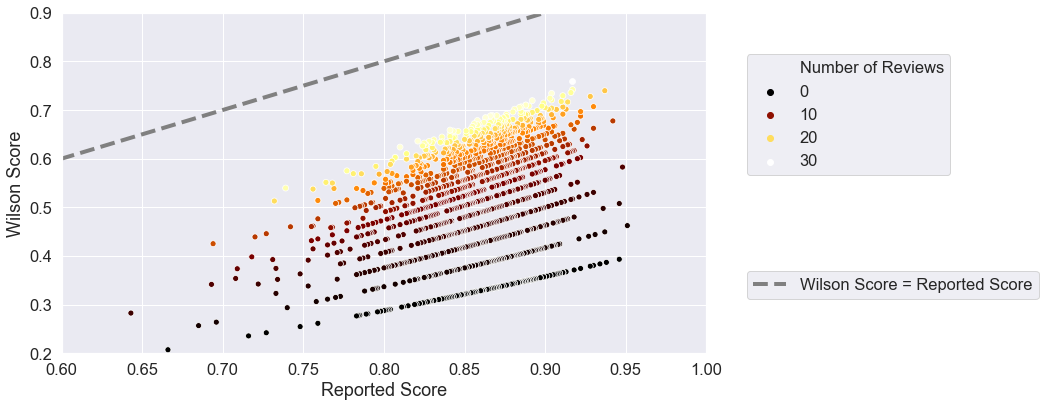

In [27]:
plt.figure(figsize=(15,6))

# Plot the whiskey data's wilson score vs. reported score
sns.scatterplot(
    "Reported Score",
    "Wilson Score",
    data=data,
    hue="Number of Reviews",
    palette="afmhot",
    zorder=5,
)
scatter_legend = plt.legend(
    bbox_to_anchor=(1.05, 0.7, 0, 0),
    loc="center left",
)

plt.xlim(0.6, 1)
plt.ylim(0.2, 0.9)

# Plot a line representing the asymptotic behavior
equal_line = plt.plot(
    [0, 1],
    [0, 1],
    linestyle="--",
    color="grey",
    linewidth=4,
    label="Wilson Score = Reported Score",
    zorder=1,
)

# Add both legends and set "tight layout"
line_legend = plt.legend(
    handles=equal_line,
    bbox_to_anchor=(1.05, 0.2, 0, 0),
    loc="center left",
)
plt.gca().add_artist(scatter_legend)
plt.tight_layout();

Again, we are able to see that for the same reported score, points with more reviews have a higher Wilson score.

Because the most-reviewed bottle only has about 30 reviews, nothing approaches the asymptotic limit of the Wilson score (marked by the dotted line).

## What cheaper bottles does the Wilson score recommend?

Let's get a quick reminder of what the cost bins are:

In [28]:
data.groupby(["Cost Ranking", "Cost"]).size().rename("Count").reset_index().sort_values("Cost Ranking")

,Cost Ranking,Cost,Count
0,1.0,< \$30 CAD,87
1,2.0,\$30-\$50 CAD,193
2,3.0,\$50-\$70 CAD,309
3,4.0,\$70-\$125 CAD,551
4,5.0,\$125-\$300 CAD,323
5,6.0,> \$300 CAD,175


In [29]:
# Let's call bottles less than 70 CAD "cheap"
cheap = data["Cost Ranking"] <= 3

In [30]:
# Top cheap bottles just by average rating
data.loc[cheap, score_columns].sort_values("Reported Score", ascending=False).head(10)

,Whisk(e)y,Reported Score,Number of Reviews,Wilson Score
143,J.P. Wiser's Alumni Series Wendel Clark 11yo,0.901,5,0.463884
151,J.P. Wiser's Dissertation,0.900,11,0.612038
163,Crown Royal Noble Collection Blender's Mash 13yo,0.899,3,0.356881
183,Compass Box Peat Monster 2014 - 10th Anniversary,0.897,12,0.622763
208,Forty Creek Unity,0.895,4,0.412560
209,J.P. Wiser's Legacy,0.895,16,0.663468
261,Compass Box Peat Monster 2008 Reserve Edition,0.891,3,0.350936
295,Jack Daniel's 150th Anniversary,0.889,3,0.349460
306,Ardbeg 10yo,0.888,25,0.710157
308,Willett Family Estate 4yo Rye,0.888,8,0.542795


In [31]:
# Top cheap bottles by Wilson score
data.loc[cheap, score_columns].sort_values("Wilson Score", ascending=False).head(10)

,Whisk(e)y,Reported Score,Number of Reviews,Wilson Score
306,Ardbeg 10yo,0.888,25,0.710157
374,Laphroaig 10yo,0.884,25,0.705285
421,Nikka From the Barrel,0.881,25,0.701650
336,Lot 40,0.886,22,0.693315
705,Bunnahabhain 12yo,0.866,26,0.687897
750,Highland Park 12yo (all reviews),0.863,26,0.684350
566,Compass Box Peat Monster (all editions),0.874,23,0.683999
596,Redbreast 12yo,0.872,23,0.681616
449,Booker's Small Batch Straight Bourbon,0.880,21,0.680585
693,Elijah Craig 12yo,0.867,24,0.680443
